In [30]:
import torch
import torch.nn as nn
import random

In [2]:
"""
To improve training times of coordMLPS often sampling of image points is used
The standard approach is to randomly select coordinate points from the image and predict with the network
This approach does not work for coordX as input values must be decomposed into their dimensional coords
ex: [(1,1),(1,2),(2,1),(2,2)] points require input x = [1,2] y = [1,2]
The paper approaches an input sampling scheme for CoordX which first samples along the input dims
Then select appropriate corresponding image points

The number of points selected along each input dimension is kept roughly in proportion 
to the size of the input dimension
Given we need to sample N number of image points and each dimension i is of length Si
The number of points sampled along dim i is mu*SI
Where mu is the scale factor

N is roughly equal to the product of i=1 -> C product of mu*Si = N
Or the product of mu times the size of each dimension where C is the number of dims
To get the scale factor they caculate

mu = c root(N/V)
where
V = i=1 -> C product of Si

or 
V = the product of each Si (dimension length)
mu = number of dimension root of (number samples / the product of each Si)

They also add some random noise to each mu*Si
"""

'\nTo improve training times of coordMLPS often sampling of image points is used\nThe standard approach is to randomly select coordinate points from the image and predict with the network\nThis approach does not work for coordX as input values must be decomposed into their dimensional coords\nex: [(1,1),(1,2),(2,1),(2,2)] points require input x = [1,2] y = [1,2]\nThe paper approaches an input sampling scheme for CoordX which first samples along the input dims\nThen select appropriate corresponding image points\n\nThe number of points selected along each input dimension is kept roughly in proportion \nto the size of the input dimension\nGiven we need to sample N number of image points and each dimension i is of length Si\nThe number of points sampled along dim i is mu*SI\nWhere mu is the scale factor\n\nN is roughly equal to the product of i=1 -> C product of mu*Si = N\nOr the product of mu times the size of each dimension where C is the number of dims\nTo get the scale factor they cacu

In [17]:
# lets give this one a try with torch tensors
img = torch.arange(0,128, 1).reshape((8,16))
img

tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14,  15],
        [ 16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,
          30,  31],
        [ 32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,
          46,  47],
        [ 48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
          62,  63],
        [ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
          78,  79],
        [ 80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
          94,  95],
        [ 96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
         110, 111],
        [112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
         126, 127]])

In [22]:
img.shape.numel()

128

In [23]:
len(img.shape)

2

In [316]:
# img has 128 "pixels" lets sample N = 64
N = 64
v = img.shape.numel() # gives number of elements in tensor
mu = (N/v)**(1/len(img.shape))
mu

0.7071067811865476

In [317]:
(8*mu) * (16*mu)

64.00000000000001

In [319]:
# Now for the fun part which is geting the samples

y_coords = img.shape[0]
x_coords = img.shape[1]

x = torch.linspace(1, x_coords, x_coords)#.reshape(x_coords,1)
y = torch.linspace(1, y_coords, y_coords)#.reshape(y_coords,1)

In [320]:
x.shape

torch.Size([16])

In [393]:
# add a bit of noise 
mu_noisy = min(random.normalvariate(mu=mu,sigma=0.05),1)

# use torch multinomial to select coordinates for each dim
dist = torch.ones(x.shape)/x_coords
num_samples = int(mu_noisy*x_coords)
x_samples = dist.multinomial(num_samples).sort().values

dist = torch.ones(y.shape)/y_coords
num_samples = int(mu_noisy*y_coords)
y_samples = dist.multinomial(num_samples).sort().values

# use torch index_select for grabbing the index of each dim
sampled_img = img.index_select(0, y_samples).index_select(1, x_samples)
sampled_img.shape

torch.Size([6, 12])

In [403]:
x_samples

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 10, 12, 14])

Train using sampling

In [1]:
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch
import os
import random
from PIL import Image
from coordx import coordx_net
from helpers import psnr
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
def accelerated_train(model, optimizer:torch.optim, dims:list[torch.Tensor], target:torch.tensor, n_epochs:int, print_step:int=1000, n_samples:int=262144):
    '''
    trains the coordx network
    @param model: the model to train
    @param optimizer: the optimizer to use
    @param dims: the input tensors containing the coordinates
    @param target: the target tensor    
    @param n_epochs: number of epochs to train for (20k for image, 100k for video)
    @param print_step: the step to print the loss
    @param n_samples: the (rough) number of pixels to sample
    '''
    y_coords = img.shape[1]
    x_coords = img.shape[2]

    v = y_coords*x_coords 
    mu = (n_samples/v)**(1/2)
    target = target.to(device)

    x_dist = torch.ones(x_coords, device=device)/x_coords
    y_dist = torch.ones(y_coords, device=device)/y_coords
    
    loss_fn = torch.nn.MSELoss()
    for epoch in range(n_epochs+1):
        # Sampling 
        # add a bit of noise 
        mu_noisy = min(random.normalvariate(mu=mu,sigma=0.01),1)

        # use torch multinomial to select coordinates for each dim
        num_samples = int(mu_noisy*x_coords)
        x_samples = x_dist.multinomial(num_samples).sort().values
        #x_in = dims[0].index_select(0, x_samples)

        num_samples = int(mu_noisy*y_coords)
        y_samples = y_dist.multinomial(num_samples).sort().values
        #y_in = dims[1].index_select(0, y_samples)

        # use torch index_select for grabbing the index of each dim
        sampled_target = target.index_select(1, y_samples).index_select(2, x_samples)

        # Training 
    
        optimizer.zero_grad()
        #out = model([x_samples.reshape(-1,1).type(torch.float).to(device), y_samples.reshape(-1,1).type(torch.float).to(device)])     
        out = model([dims[0].index_select(0, x_samples), dims[1].index_select(0, y_samples)])     
        loss = loss_fn(out, sampled_target)
        loss.backward()
        optimizer.step()
        if epoch % print_step == 0:
            print(f'Iteration: {epoch} | Loss: {loss.item()}')

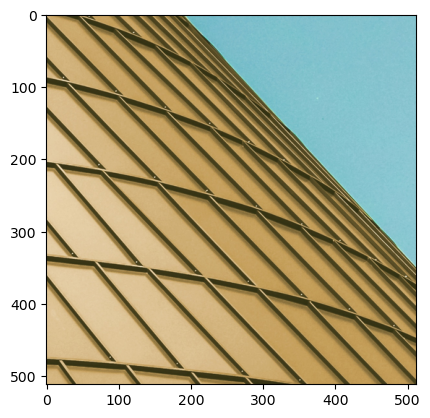

In [8]:
# load a random div2k image
n = str(random.randint(1, 801)).zfill(4)
img = Image.open(f'div2k/DIV2k_train_HR/{n}.png')
transforms = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop(512),    
    torchvision.transforms.ToTensor()
])
img = transforms(img)
plt.imshow(img.permute(1, 2, 0))

In [9]:
y_coords = img.shape[1]
x_coords = img.shape[2]

x = torch.linspace(1, x_coords, x_coords).reshape(-1,1).to(device)
y = torch.linspace(1, y_coords, y_coords).reshape(-1,1).to(device)

In [10]:
# example: training a coordx network for image (2 branches) with a scale factor of 2 on the last hidden layer before the fusion
model = coordx_net(n_branches=2, out_channels=3, hidden_size=256, R=2, R_strat=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) #lr=0.001 for image works if you do a low #epcohs, but n>2000 = unstable
accelerated_train(model=model, optimizer=optimizer, dims=[x,y], target=img, n_epochs=20000, print_step=500, n_samples=131072)

Iteration: 0 | Loss: 0.0953572690486908
Iteration: 500 | Loss: 0.026915056630969048
Iteration: 1000 | Loss: 0.015305803157389164
Iteration: 1500 | Loss: 0.008508170023560524
Iteration: 2000 | Loss: 0.005375998560339212
Iteration: 2500 | Loss: 0.0037765747401863337
Iteration: 3000 | Loss: 0.002808128483593464
Iteration: 3500 | Loss: 0.002192404353991151
Iteration: 4000 | Loss: 0.0018014658708125353
Iteration: 4500 | Loss: 0.0014851464657112956
Iteration: 5000 | Loss: 0.001242865459062159
Iteration: 5500 | Loss: 0.0009761877008713782
Iteration: 6000 | Loss: 0.0007710510399192572
Iteration: 6500 | Loss: 0.0006381808198057115
Iteration: 7000 | Loss: 0.0005509877228178084
Iteration: 7500 | Loss: 0.0004924820968881249
Iteration: 8000 | Loss: 0.0004369110974948853
Iteration: 8500 | Loss: 0.00038904318353161216
Iteration: 9000 | Loss: 0.0003353644860908389
Iteration: 9500 | Loss: 0.0003033311804756522
Iteration: 10000 | Loss: 0.00028118814225308597
Iteration: 10500 | Loss: 0.000259748921962454

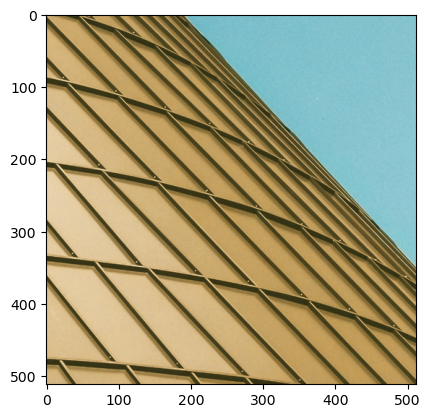

PSNR: 39.04248046875


In [12]:
final = model([x,y])
plt.imshow(final.detach().cpu().permute(1, 2, 0).numpy())
plt.show()
print(f'PSNR: {psnr(img, final.cpu())}')

In [13]:
# example: training a coordx network for image (2 branches) with a scale factor of 2 on the last hidden layer before the fusion
model = coordx_net(n_branches=2, out_channels=3, hidden_size=256, R=2, R_strat=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) #lr=0.001 for image works if you do a low #epcohs, but n>2000 = unstable
accelerated_train(model=model, optimizer=optimizer, dims=[x,y], target=img, n_epochs=20000, print_step=500, n_samples=int((512*512)/10))

Iteration: 0 | Loss: 0.093381367623806
Iteration: 500 | Loss: 0.033083803951740265
Iteration: 1000 | Loss: 0.023129967972636223
Iteration: 1500 | Loss: 0.017208855599164963
Iteration: 2000 | Loss: 0.012404229491949081
Iteration: 2500 | Loss: 0.00914936326444149
Iteration: 3000 | Loss: 0.007215851452201605
Iteration: 3500 | Loss: 0.005516857840120792
Iteration: 4000 | Loss: 0.004631684627383947
Iteration: 4500 | Loss: 0.0038585015572607517
Iteration: 5000 | Loss: 0.003318642033264041
Iteration: 5500 | Loss: 0.002877179067581892
Iteration: 6000 | Loss: 0.002413832815364003
Iteration: 6500 | Loss: 0.0020403359085321426
Iteration: 7000 | Loss: 0.0017848566640168428
Iteration: 7500 | Loss: 0.0015354693168774247
Iteration: 8000 | Loss: 0.0013623872073367238
Iteration: 8500 | Loss: 0.0012313922634348273
Iteration: 9000 | Loss: 0.0011150625068694353
Iteration: 9500 | Loss: 0.0009504883782938123
Iteration: 10000 | Loss: 0.0008772797882556915
Iteration: 10500 | Loss: 0.0008185437181964517
Iterat

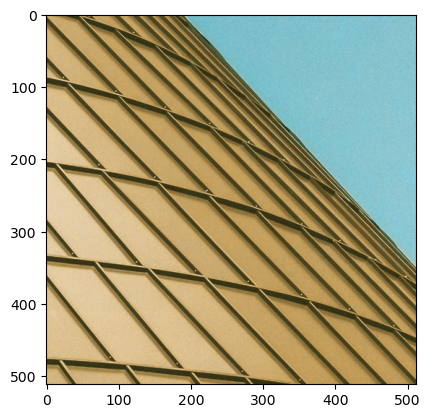

PSNR: 35.40305709838867


In [14]:
final = model([x,y])
plt.imshow(final.detach().cpu().permute(1, 2, 0).numpy())
plt.show()
print(f'PSNR: {psnr(img, final.cpu())}')

Regular train for reference

In [15]:
def train(model, optimizer:torch.optim, dims:list[torch.tensor], target:torch.tensor, n_epochs:int, print_step:int=1000):
    '''
    trains the coordx network
    @param model: the model to train
    @param optimizer: the optimizer to use
    @param dims: the input tensors containing the coordinates
    @param target: the target tensor    
    @param n_epochs: number of epochs to train for (20k for image, 100k for video)
    @param print_step: the step to print the loss
    '''
    loss_fn = torch.nn.MSELoss()
    for epoch in range(n_epochs+1):
        optimizer.zero_grad()
        out = model(dims)        
        loss = loss_fn(out, target)
        loss.backward()
        optimizer.step()
        if epoch % print_step == 0:
            print(f'Iteration: {epoch} | Loss: {loss.item()}')

In [16]:
# example: training a coordx network for image (2 branches) with a scale factor of 2 on the last hidden layer before the fusion
model_un = coordx_net(n_branches=2, out_channels=3, hidden_size=256, R=2, R_strat=1).to(device)
optimizer = torch.optim.Adam(model_un.parameters(), lr=0.0001) #lr=0.001 for image works if you do a low #epcohs, but n>2000 = unstable
x = x.to(device)
y = y.to(device)
train(model=model_un, optimizer=optimizer, dims=[x,y], target=img.to(device), n_epochs=20000, print_step=500)

Iteration: 0 | Loss: 0.09666572511196136
Iteration: 500 | Loss: 0.021380146965384483
Iteration: 1000 | Loss: 0.009752169251441956
Iteration: 1500 | Loss: 0.005112173035740852
Iteration: 2000 | Loss: 0.0031799122225493193
Iteration: 2500 | Loss: 0.0021938015706837177
Iteration: 3000 | Loss: 0.001613097032532096
Iteration: 3500 | Loss: 0.0012388997711241245
Iteration: 4000 | Loss: 0.0009798939572647214
Iteration: 4500 | Loss: 0.0007584791164845228
Iteration: 5000 | Loss: 0.0005348588456399739
Iteration: 5500 | Loss: 0.00040539144538342953
Iteration: 6000 | Loss: 0.00033582429750822484
Iteration: 6500 | Loss: 0.000287135859252885
Iteration: 7000 | Loss: 0.00025132554583251476
Iteration: 7500 | Loss: 0.00022075585729908198
Iteration: 8000 | Loss: 0.00019437870651017874
Iteration: 8500 | Loss: 0.0001734616089379415
Iteration: 9000 | Loss: 0.00015623506624251604
Iteration: 9500 | Loss: 0.00014279589231591672
Iteration: 10000 | Loss: 0.00013200362445786595
Iteration: 10500 | Loss: 0.000124443

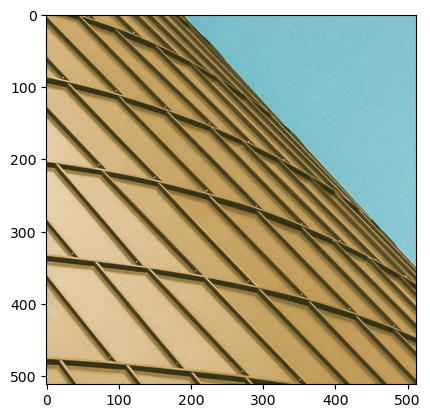

PSNR: 40.947059631347656


In [17]:
final = model_un([x,y])
plt.imshow(final.detach().cpu().permute(1, 2, 0).numpy())
plt.show()
print(f'PSNR: {psnr(img, final.cpu())}')

It seems like they are getting way lower train times with higher psnr, what happens if you rig images

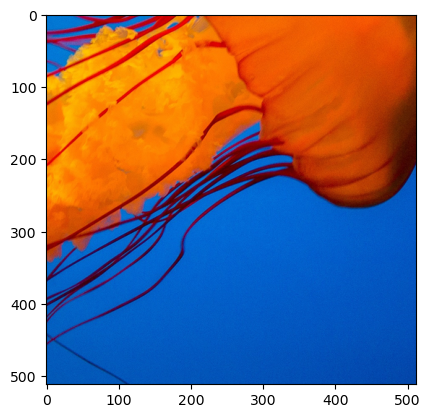

In [19]:
n = 48
n = str(n).zfill(4)
img = Image.open(f'div2k/DIV2k_train_HR/{n}.png')
transforms = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop(512),    
    torchvision.transforms.ToTensor()
])
img = transforms(img)
plt.imshow(img.permute(1, 2, 0))

In [20]:
y_coords = img.shape[1]
x_coords = img.shape[2]

x = torch.linspace(1, x_coords, x_coords).reshape(-1,1).to(device)
y = torch.linspace(1, y_coords, y_coords).reshape(-1,1).to(device)

In [21]:
# example: training a coordx network for image (2 branches) with a scale factor of 2 on the last hidden layer before the fusion
model_un = coordx_net(n_branches=2, out_channels=3, hidden_size=256, R=2, R_strat=1).to(device)
optimizer = torch.optim.Adam(model_un.parameters(), lr=0.0001) #lr=0.001 for image works if you do a low #epcohs, but n>2000 = unstable
x = x.to(device)
y = y.to(device)
train(model=model_un, optimizer=optimizer, dims=[x,y], target=img.to(device), n_epochs=20000, print_step=500)

Iteration: 0 | Loss: 0.16580401360988617
Iteration: 500 | Loss: 0.011264828965067863
Iteration: 1000 | Loss: 0.006638327147811651
Iteration: 1500 | Loss: 0.003922590985894203
Iteration: 2000 | Loss: 0.0023026063572615385
Iteration: 2500 | Loss: 0.001430654781870544
Iteration: 3000 | Loss: 0.0009569100802764297
Iteration: 3500 | Loss: 0.0006820735288783908
Iteration: 4000 | Loss: 0.0005122169386595488
Iteration: 4500 | Loss: 0.00039980182191357017
Iteration: 5000 | Loss: 0.0003228142159059644
Iteration: 5500 | Loss: 0.0002677346346899867
Iteration: 6000 | Loss: 0.00022665585856884718
Iteration: 6500 | Loss: 0.00019559060456231236
Iteration: 7000 | Loss: 0.0001719939464237541
Iteration: 7500 | Loss: 0.0001532024034531787
Iteration: 8000 | Loss: 0.0001388039527228102
Iteration: 8500 | Loss: 0.00012653539306484163
Iteration: 9000 | Loss: 0.00011689448729157448
Iteration: 9500 | Loss: 0.00010896990715991706
Iteration: 10000 | Loss: 0.0001023502554744482
Iteration: 10500 | Loss: 9.6907569968

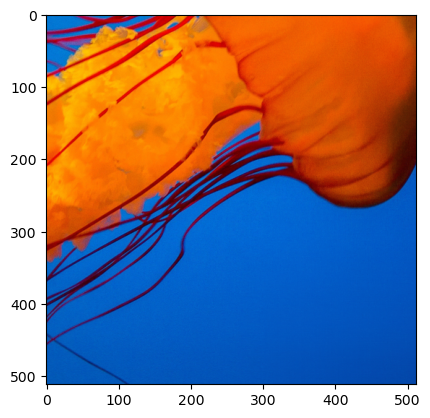

PSNR: 42.0420036315918


In [22]:
final = model_un([x,y])
plt.imshow(final.detach().cpu().permute(1, 2, 0).numpy())
plt.show()
print(f'PSNR: {psnr(img, final.cpu())}')

In [23]:
# Train with samples = N / 2
model = coordx_net(n_branches=2, out_channels=3, hidden_size=256, R=2, R_strat=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) #lr=0.001 for image works if you do a low #epcohs, but n>2000 = unstable
accelerated_train(model=model, optimizer=optimizer, dims=[x,y], target=img, n_epochs=20000, print_step=500, n_samples=int((512*512)/2))

Iteration: 0 | Loss: 0.1721358299255371
Iteration: 500 | Loss: 0.013743683695793152
Iteration: 1000 | Loss: 0.008705331943929195
Iteration: 1500 | Loss: 0.0052244337275624275
Iteration: 2000 | Loss: 0.003529865760356188
Iteration: 2500 | Loss: 0.0023272887337952852
Iteration: 3000 | Loss: 0.0016017722664400935
Iteration: 3500 | Loss: 0.0011321885976940393
Iteration: 4000 | Loss: 0.0008555654203519225
Iteration: 4500 | Loss: 0.0006529982783831656
Iteration: 5000 | Loss: 0.0005095528904348612
Iteration: 5500 | Loss: 0.00042478088289499283
Iteration: 6000 | Loss: 0.0003488091751933098
Iteration: 6500 | Loss: 0.0002981798897963017
Iteration: 7000 | Loss: 0.00025662477128207684
Iteration: 7500 | Loss: 0.00022749461641069502
Iteration: 8000 | Loss: 0.00020535038493108004
Iteration: 8500 | Loss: 0.0001895211753435433
Iteration: 9000 | Loss: 0.00017119866970460862
Iteration: 9500 | Loss: 0.00015834200894460082
Iteration: 10000 | Loss: 0.00015029108908493072
Iteration: 10500 | Loss: 0.000140694

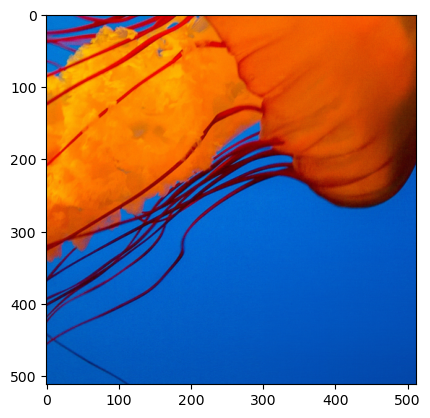

PSNR: 40.76656723022461


In [24]:
final = model([x,y])
plt.imshow(final.detach().cpu().permute(1, 2, 0).numpy())
plt.show()
print(f'PSNR: {psnr(img, final.cpu())}')

In [25]:
# Train with samples = N / 4
model = coordx_net(n_branches=2, out_channels=3, hidden_size=256, R=2, R_strat=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) #lr=0.001 for image works if you do a low #epcohs, but n>2000 = unstable
accelerated_train(model=model, optimizer=optimizer, dims=[x,y], target=img, n_epochs=20000, print_step=500, n_samples=int((512*512)/4))

Iteration: 0 | Loss: 0.16677623987197876
Iteration: 500 | Loss: 0.020879346877336502
Iteration: 1000 | Loss: 0.012032565660774708
Iteration: 1500 | Loss: 0.008433258160948753
Iteration: 2000 | Loss: 0.006729446817189455
Iteration: 2500 | Loss: 0.004689972847700119
Iteration: 3000 | Loss: 0.0033593582920730114
Iteration: 3500 | Loss: 0.0027050136122852564
Iteration: 4000 | Loss: 0.0021266243420541286
Iteration: 4500 | Loss: 0.0016439453465864062
Iteration: 5000 | Loss: 0.0012677946360781789
Iteration: 5500 | Loss: 0.0010282122530043125
Iteration: 6000 | Loss: 0.000857076607644558
Iteration: 6500 | Loss: 0.000655494281090796
Iteration: 7000 | Loss: 0.0005906036240048707
Iteration: 7500 | Loss: 0.00046164647210389376
Iteration: 8000 | Loss: 0.0004313835233915597
Iteration: 8500 | Loss: 0.00036011493648402393
Iteration: 9000 | Loss: 0.0003457113343756646
Iteration: 9500 | Loss: 0.0003203504311386496
Iteration: 10000 | Loss: 0.00028732913779094815
Iteration: 10500 | Loss: 0.0002697656454984

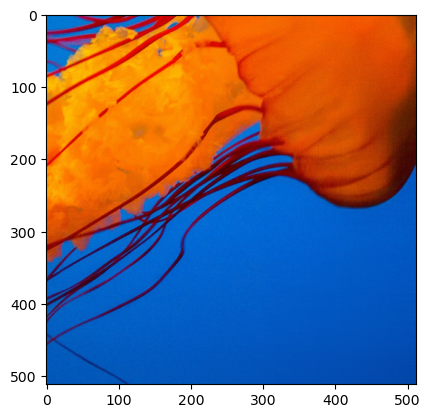

PSNR: 38.66965103149414


In [26]:
final = model([x,y])
plt.imshow(final.detach().cpu().permute(1, 2, 0).numpy())
plt.show()
print(f'PSNR: {psnr(img, final.cpu())}')

In [27]:
# Train with samples = N / 8
model = coordx_net(n_branches=2, out_channels=3, hidden_size=256, R=2, R_strat=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) #lr=0.001 for image works if you do a low #epcohs, but n>2000 = unstable
accelerated_train(model=model, optimizer=optimizer, dims=[x,y], target=img, n_epochs=20000, print_step=500, n_samples=int((512*512)/8))

Iteration: 0 | Loss: 0.16789649426937103
Iteration: 500 | Loss: 0.027749760076403618
Iteration: 1000 | Loss: 0.013306738808751106
Iteration: 1500 | Loss: 0.010565723292529583
Iteration: 2000 | Loss: 0.00795441959053278
Iteration: 2500 | Loss: 0.005978284869343042
Iteration: 3000 | Loss: 0.004530161619186401
Iteration: 3500 | Loss: 0.0037751232739537954
Iteration: 4000 | Loss: 0.0028463350608944893
Iteration: 4500 | Loss: 0.002198335248976946
Iteration: 5000 | Loss: 0.0017443683464080095
Iteration: 5500 | Loss: 0.0013978497590869665
Iteration: 6000 | Loss: 0.0012260122457519174
Iteration: 6500 | Loss: 0.0010564248077571392
Iteration: 7000 | Loss: 0.0008791381842456758
Iteration: 7500 | Loss: 0.0007998972432687879
Iteration: 8000 | Loss: 0.0006477439892478287
Iteration: 8500 | Loss: 0.0005978988483548164
Iteration: 9000 | Loss: 0.0005124353338032961
Iteration: 9500 | Loss: 0.0004766304336953908
Iteration: 10000 | Loss: 0.0004539605288300663
Iteration: 10500 | Loss: 0.00038552164915017784

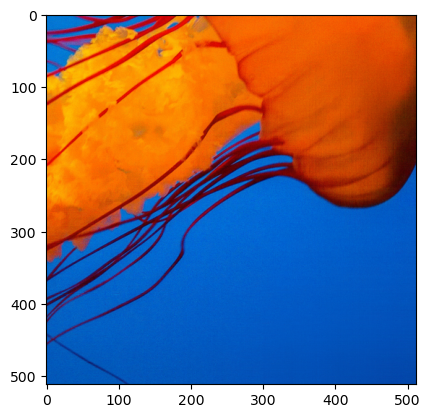

PSNR: 37.06172180175781


In [28]:
final = model([x,y])
plt.imshow(final.detach().cpu().permute(1, 2, 0).numpy())
plt.show()
print(f'PSNR: {psnr(img, final.cpu())}')

In [29]:
# Train with samples = N / 16
model = coordx_net(n_branches=2, out_channels=3, hidden_size=256, R=2, R_strat=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) #lr=0.001 for image works if you do a low #epcohs, but n>2000 = unstable
accelerated_train(model=model, optimizer=optimizer, dims=[x,y], target=img, n_epochs=20000, print_step=500, n_samples=int((512*512)/16))

Iteration: 0 | Loss: 0.16579920053482056
Iteration: 500 | Loss: 0.029273955151438713
Iteration: 1000 | Loss: 0.01610548235476017
Iteration: 1500 | Loss: 0.011905994266271591
Iteration: 2000 | Loss: 0.009661933407187462
Iteration: 2500 | Loss: 0.007765560876578093
Iteration: 3000 | Loss: 0.006387470290064812
Iteration: 3500 | Loss: 0.004961042199283838
Iteration: 4000 | Loss: 0.0044568427838385105
Iteration: 4500 | Loss: 0.0035776314325630665
Iteration: 5000 | Loss: 0.0028029028326272964
Iteration: 5500 | Loss: 0.002312085824087262
Iteration: 6000 | Loss: 0.002143020974472165
Iteration: 6500 | Loss: 0.0017644425388425589
Iteration: 7000 | Loss: 0.0015474790707230568
Iteration: 7500 | Loss: 0.0013104119570925832
Iteration: 8000 | Loss: 0.0011025294661521912
Iteration: 8500 | Loss: 0.0010555869666859508
Iteration: 9000 | Loss: 0.0008963401196524501
Iteration: 9500 | Loss: 0.0008000016678124666
Iteration: 10000 | Loss: 0.0007751582306809723
Iteration: 10500 | Loss: 0.0006495980778709054
It

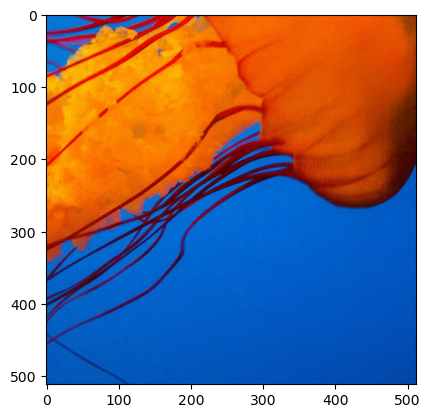

PSNR: 35.81037139892578


In [30]:
final = model([x,y])
plt.imshow(final.detach().cpu().permute(1, 2, 0).numpy())
plt.show()
print(f'PSNR: {psnr(img, final.cpu())}')

In [31]:
# Train with samples = N / 32
model = coordx_net(n_branches=2, out_channels=3, hidden_size=256, R=2, R_strat=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) #lr=0.001 for image works if you do a low #epcohs, but n>2000 = unstable
accelerated_train(model=model, optimizer=optimizer, dims=[x,y], target=img, n_epochs=20000, print_step=500, n_samples=int((512*512)/32))

Iteration: 0 | Loss: 0.172394260764122
Iteration: 500 | Loss: 0.03184181824326515
Iteration: 1000 | Loss: 0.01699092425405979
Iteration: 1500 | Loss: 0.01289547048509121
Iteration: 2000 | Loss: 0.011481786146759987
Iteration: 2500 | Loss: 0.009433327242732048
Iteration: 3000 | Loss: 0.00797184370458126
Iteration: 3500 | Loss: 0.006649572867900133
Iteration: 4000 | Loss: 0.005003778729587793
Iteration: 4500 | Loss: 0.003971179015934467
Iteration: 5000 | Loss: 0.004056009463965893
Iteration: 5500 | Loss: 0.0034441284369677305
Iteration: 6000 | Loss: 0.002554848790168762
Iteration: 6500 | Loss: 0.0022508841939270496
Iteration: 7000 | Loss: 0.0019205354619771242
Iteration: 7500 | Loss: 0.0018371205078437924
Iteration: 8000 | Loss: 0.001713334466330707
Iteration: 8500 | Loss: 0.0014535235241055489
Iteration: 9000 | Loss: 0.0013002629857510328
Iteration: 9500 | Loss: 0.0011481078108772635
Iteration: 10000 | Loss: 0.0009225873509421945
Iteration: 10500 | Loss: 0.0009414838277734816
Iteration:

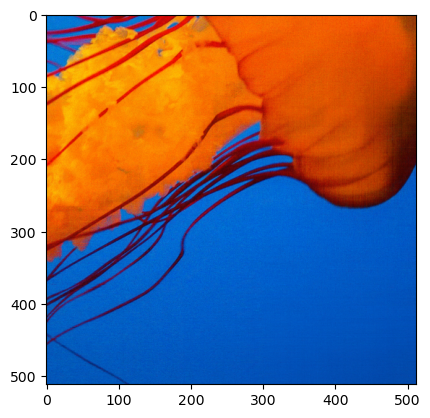

PSNR: 34.18120193481445


In [32]:
final = model([x,y])
plt.imshow(final.detach().cpu().permute(1, 2, 0).numpy())
plt.show()
print(f'PSNR: {psnr(img, final.cpu())}')

In [33]:
# Train with samples = N / 64
model = coordx_net(n_branches=2, out_channels=3, hidden_size=256, R=2, R_strat=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) #lr=0.001 for image works if you do a low #epcohs, but n>2000 = unstable
accelerated_train(model=model, optimizer=optimizer, dims=[x,y], target=img, n_epochs=20000, print_step=500, n_samples=int((512*512)/64))

Iteration: 0 | Loss: 0.16536705195903778
Iteration: 500 | Loss: 0.038988348096609116
Iteration: 1000 | Loss: 0.018954800441861153
Iteration: 1500 | Loss: 0.013072945177555084
Iteration: 2000 | Loss: 0.012707309797406197
Iteration: 2500 | Loss: 0.008776807226240635
Iteration: 3000 | Loss: 0.007923572324216366
Iteration: 3500 | Loss: 0.0051550655625760555
Iteration: 4000 | Loss: 0.006143603939563036
Iteration: 4500 | Loss: 0.004497081972658634
Iteration: 5000 | Loss: 0.0037036475259810686
Iteration: 5500 | Loss: 0.0029861319344490767
Iteration: 6000 | Loss: 0.0032597507815808058
Iteration: 6500 | Loss: 0.002674991264939308
Iteration: 7000 | Loss: 0.002189499093219638
Iteration: 7500 | Loss: 0.0015875576063990593
Iteration: 8000 | Loss: 0.001509855967015028
Iteration: 8500 | Loss: 0.0013181805843487382
Iteration: 9000 | Loss: 0.0011983735021203756
Iteration: 9500 | Loss: 0.0012064531911164522
Iteration: 10000 | Loss: 0.0009513054974377155
Iteration: 10500 | Loss: 0.001078366651199758
Iter

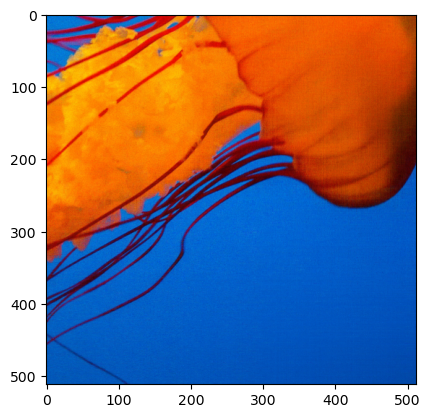

PSNR: 34.4848747253418


In [34]:
final = model([x,y])
plt.imshow(final.detach().cpu().permute(1, 2, 0).numpy())
plt.show()
print(f'PSNR: {psnr(img, final.cpu())}')

In [35]:
# Train with samples = N / 128
model = coordx_net(n_branches=2, out_channels=3, hidden_size=256, R=2, R_strat=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) #lr=0.001 for image works if you do a low #epcohs, but n>2000 = unstable
accelerated_train(model=model, optimizer=optimizer, dims=[x,y], target=img, n_epochs=20000, print_step=500, n_samples=int((512*512)/128))

Iteration: 0 | Loss: 0.16381904482841492
Iteration: 500 | Loss: 0.04575841501355171
Iteration: 1000 | Loss: 0.03463996201753616
Iteration: 1500 | Loss: 0.01865478605031967
Iteration: 2000 | Loss: 0.012837129645049572
Iteration: 2500 | Loss: 0.010551894083619118
Iteration: 3000 | Loss: 0.010710218921303749
Iteration: 3500 | Loss: 0.009016751311719418
Iteration: 4000 | Loss: 0.008843128569424152
Iteration: 4500 | Loss: 0.0068585858680307865
Iteration: 5000 | Loss: 0.006079689133912325
Iteration: 5500 | Loss: 0.005967968609184027
Iteration: 6000 | Loss: 0.005195769481360912
Iteration: 6500 | Loss: 0.004629908129572868
Iteration: 7000 | Loss: 0.004964066669344902
Iteration: 7500 | Loss: 0.004735770169645548
Iteration: 8000 | Loss: 0.003859064308926463
Iteration: 8500 | Loss: 0.003092339728027582
Iteration: 9000 | Loss: 0.0028396244160830975
Iteration: 9500 | Loss: 0.0028230417519807816
Iteration: 10000 | Loss: 0.0027656150050461292
Iteration: 10500 | Loss: 0.002386391395702958
Iteration: 1

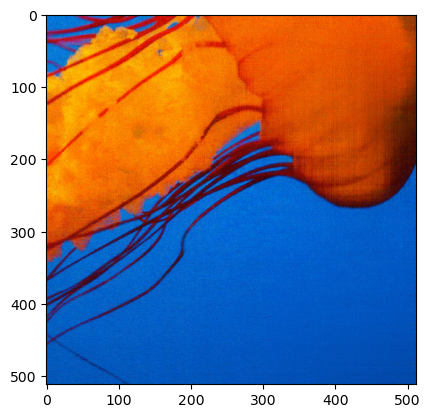

PSNR: 30.67633819580078


In [36]:
final = model([x,y])
plt.imshow(final.detach().cpu().permute(1, 2, 0).numpy())
plt.show()
print(f'PSNR: {psnr(img, final.cpu())}')

In [37]:
# Train with samples = N / 256
model = coordx_net(n_branches=2, out_channels=3, hidden_size=256, R=2, R_strat=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) #lr=0.001 for image works if you do a low #epcohs, but n>2000 = unstable
accelerated_train(model=model, optimizer=optimizer, dims=[x,y], target=img, n_epochs=20000, print_step=500, n_samples=int((512*512)/256))

Iteration: 0 | Loss: 0.16801393032073975
Iteration: 500 | Loss: 0.07373163104057312
Iteration: 1000 | Loss: 0.0378434918820858
Iteration: 1500 | Loss: 0.02830566093325615
Iteration: 2000 | Loss: 0.02362830564379692
Iteration: 2500 | Loss: 0.01618831977248192
Iteration: 3000 | Loss: 0.01650373637676239
Iteration: 3500 | Loss: 0.015540104359388351
Iteration: 4000 | Loss: 0.009747589938342571
Iteration: 4500 | Loss: 0.009352334775030613
Iteration: 5000 | Loss: 0.013107364997267723
Iteration: 5500 | Loss: 0.012885399162769318
Iteration: 6000 | Loss: 0.0099416458979249
Iteration: 6500 | Loss: 0.006761255208402872
Iteration: 7000 | Loss: 0.008437009528279305
Iteration: 7500 | Loss: 0.00714076915755868
Iteration: 8000 | Loss: 0.008181323297321796
Iteration: 8500 | Loss: 0.0056188274174928665
Iteration: 9000 | Loss: 0.007376534398645163
Iteration: 9500 | Loss: 0.005420960485935211
Iteration: 10000 | Loss: 0.005427227821201086
Iteration: 10500 | Loss: 0.00524431886151433
Iteration: 11000 | Loss

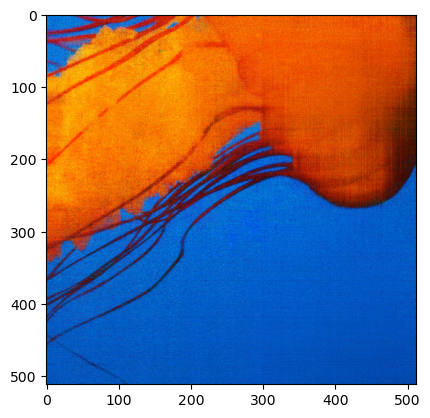

PSNR: 26.83255958557129


In [38]:
final = model([x,y])
plt.imshow(final.detach().cpu().permute(1, 2, 0).numpy())
plt.show()
print(f'PSNR: {psnr(img, final.cpu())}')

Test how long sampling itself is taking

In [39]:
def ablated_accelerated_train(model, optimizer:torch.optim, dims:list[torch.Tensor], target:torch.tensor, n_epochs:int, print_step:int=1000, n_samples:int=262144):
    '''
    trains the coordx network
    @param model: the model to train
    @param optimizer: the optimizer to use
    @param dims: the input tensors containing the coordinates
    @param target: the target tensor    
    @param n_epochs: number of epochs to train for (20k for image, 100k for video)
    @param print_step: the step to print the loss
    @param n_samples: the (rough) number of pixels to sample
    '''
    y_coords = img.shape[1]
    x_coords = img.shape[2]

    v = y_coords*x_coords 
    mu = (n_samples/v)**(1/2)
    target = target.to(device)

    x_dist = torch.ones(x_coords, device=device)/x_coords
    y_dist = torch.ones(y_coords, device=device)/y_coords
    
    loss_fn = torch.nn.MSELoss()
    for epoch in range(n_epochs+1):
        # Sampling 
        # add a bit of noise 
        mu_noisy = min(random.normalvariate(mu=mu,sigma=0.01),1)

        # use torch multinomial to select coordinates for each dim
        num_samples = int(mu_noisy*x_coords)
        x_samples = x_dist.multinomial(num_samples).sort().values
        x_in = dims[0].index_select(0, x_samples)

        num_samples = int(mu_noisy*y_coords)
        y_samples = y_dist.multinomial(num_samples).sort().values
        y_in = dims[1].index_select(0, y_samples)

        # use torch index_select for grabbing the index of each dim
        sampled_target = target.index_select(1, y_samples).index_select(2, x_samples)

        # Training 
    
        #optimizer.zero_grad()
        ##out = model([x_samples.reshape(-1,1).type(torch.float).to(device), y_samples.reshape(-1,1).type(torch.float).to(device)])     
        #out = model([dims[0].index_select(0, x_samples), dims[1].index_select(0, y_samples)])     
        #loss = loss_fn(out, sampled_target)
        #loss.backward()
        #optimizer.step()
        if epoch % print_step == 0:
            print(f'Iteration: {epoch} {x_in.shape, y_in.shape, sampled_target.shape}')#| Loss: {loss.item()}')

In [41]:
# Train with samples = N / 2
model = coordx_net(n_branches=2, out_channels=3, hidden_size=256, R=2, R_strat=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) #lr=0.001 for image works if you do a low #epcohs, but n>2000 = unstable
ablated_accelerated_train(model=model, optimizer=optimizer, dims=[x,y], target=img, n_epochs=20000, print_step=500, n_samples=int((512*512)/2))

Iteration: 0 (torch.Size([353, 1]), torch.Size([353, 1]), torch.Size([3, 353, 353]))
Iteration: 500 (torch.Size([365, 1]), torch.Size([365, 1]), torch.Size([3, 365, 365]))
Iteration: 1000 (torch.Size([354, 1]), torch.Size([354, 1]), torch.Size([3, 354, 354]))
Iteration: 1500 (torch.Size([358, 1]), torch.Size([358, 1]), torch.Size([3, 358, 358]))
Iteration: 2000 (torch.Size([359, 1]), torch.Size([359, 1]), torch.Size([3, 359, 359]))
Iteration: 2500 (torch.Size([361, 1]), torch.Size([361, 1]), torch.Size([3, 361, 361]))
Iteration: 3000 (torch.Size([367, 1]), torch.Size([367, 1]), torch.Size([3, 367, 367]))
Iteration: 3500 (torch.Size([364, 1]), torch.Size([364, 1]), torch.Size([3, 364, 364]))
Iteration: 4000 (torch.Size([350, 1]), torch.Size([350, 1]), torch.Size([3, 350, 350]))
Iteration: 4500 (torch.Size([358, 1]), torch.Size([358, 1]), torch.Size([3, 358, 358]))
Iteration: 5000 (torch.Size([364, 1]), torch.Size([364, 1]), torch.Size([3, 364, 364]))
Iteration: 5500 (torch.Size([360, 1]

In [42]:
# Train with samples = N / 2
model = coordx_net(n_branches=2, out_channels=3, hidden_size=256, R=2, R_strat=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) #lr=0.001 for image works if you do a low #epcohs, but n>2000 = unstable
ablated_accelerated_train(model=model, optimizer=optimizer, dims=[x,y], target=img, n_epochs=20000, print_step=500, n_samples=int((512*512)/10))

Iteration: 0 (torch.Size([170, 1]), torch.Size([170, 1]), torch.Size([3, 170, 170]))
Iteration: 500 (torch.Size([169, 1]), torch.Size([169, 1]), torch.Size([3, 169, 169]))
Iteration: 1000 (torch.Size([161, 1]), torch.Size([161, 1]), torch.Size([3, 161, 161]))
Iteration: 1500 (torch.Size([156, 1]), torch.Size([156, 1]), torch.Size([3, 156, 156]))
Iteration: 2000 (torch.Size([165, 1]), torch.Size([165, 1]), torch.Size([3, 165, 165]))
Iteration: 2500 (torch.Size([154, 1]), torch.Size([154, 1]), torch.Size([3, 154, 154]))
Iteration: 3000 (torch.Size([160, 1]), torch.Size([160, 1]), torch.Size([3, 160, 160]))
Iteration: 3500 (torch.Size([151, 1]), torch.Size([151, 1]), torch.Size([3, 151, 151]))
Iteration: 4000 (torch.Size([164, 1]), torch.Size([164, 1]), torch.Size([3, 164, 164]))
Iteration: 4500 (torch.Size([160, 1]), torch.Size([160, 1]), torch.Size([3, 160, 160]))
Iteration: 5000 (torch.Size([158, 1]), torch.Size([158, 1]), torch.Size([3, 158, 158]))
Iteration: 5500 (torch.Size([165, 1]

In [43]:
# Train with samples = N / 128
model = coordx_net(n_branches=2, out_channels=3, hidden_size=256, R=2, R_strat=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) #lr=0.001 for image works if you do a low #epcohs, but n>2000 = unstable
ablated_accelerated_train(model=model, optimizer=optimizer, dims=[x,y], target=img, n_epochs=20000, print_step=500, n_samples=int((512*512)/128))

Iteration: 0 (torch.Size([45, 1]), torch.Size([45, 1]), torch.Size([3, 45, 45]))
Iteration: 500 (torch.Size([41, 1]), torch.Size([41, 1]), torch.Size([3, 41, 41]))
Iteration: 1000 (torch.Size([49, 1]), torch.Size([49, 1]), torch.Size([3, 49, 49]))
Iteration: 1500 (torch.Size([43, 1]), torch.Size([43, 1]), torch.Size([3, 43, 43]))
Iteration: 2000 (torch.Size([46, 1]), torch.Size([46, 1]), torch.Size([3, 46, 46]))
Iteration: 2500 (torch.Size([45, 1]), torch.Size([45, 1]), torch.Size([3, 45, 45]))
Iteration: 3000 (torch.Size([49, 1]), torch.Size([49, 1]), torch.Size([3, 49, 49]))
Iteration: 3500 (torch.Size([38, 1]), torch.Size([38, 1]), torch.Size([3, 38, 38]))
Iteration: 4000 (torch.Size([39, 1]), torch.Size([39, 1]), torch.Size([3, 39, 39]))
Iteration: 4500 (torch.Size([45, 1]), torch.Size([45, 1]), torch.Size([3, 45, 45]))
Iteration: 5000 (torch.Size([35, 1]), torch.Size([35, 1]), torch.Size([3, 35, 35]))
Iteration: 5500 (torch.Size([43, 1]), torch.Size([43, 1]), torch.Size([3, 43, 43